## generate hierarchical clustering artwork and haplotype groups
- using whole genome phasing 
- based upon Ag1000g phase 1 paper

In [1]:
%run setup.ipynb
%matplotlib inline
import hapclust

from scipy.cluster.hierarchy import _convert_to_double
from scipy.spatial import distance
from scipy.cluster.hierarchy import _hierarchy

## setup data

In [2]:
# define the gene region
region = 'PARA'
region_vgsc = '2L', 2358158, 2431617

In [3]:
def load_data(chrom, start=None, stop=None, n_variants=None):
    
    # load data
    callset_haps = np.load('../data/haps_phase1.npz')
    haps = allel.HaplotypeArray(callset_haps['haplotypes'])
    pos = allel.SortedIndex(callset_haps['POS'])
    ann = callset_haps['ANN']

    
    # locate the region of interest
    if start and stop:
        loc = pos.locate_range(start, stop)
    elif start and n_variants:
        start_idx = bisect.bisect_left(pos, start)
        stop_idx = start_idx + n_variants
        loc = slice(start_idx, stop_idx)
    elif stop and n_variants:
        stop_idx = bisect.bisect_right(pos, stop)
        start_idx = stop_idx - n_variants
        loc = slice(start_idx, stop_idx)
    else:
        raise ValueError('bad args')
    
    # obtain haplotypes for the region of interest
    pos = pos[loc]
    h = haps[loc]
    
    #setup missense
    tbl_variants_selected = etl.frompickle('../data/tbl_variants_missense_selected.pkl')

    tbl_selected_redux = (
    tbl_variants_selected
    .cut('POS', 'REF', 'ALT', 'AGAP004707-RA')
    .mergeduplicates(key=('POS'))
    .convert('ALT', lambda v: ','.join(v) if len(v) > 1 else v)
    .addfield('label',  lambda rec: '%s:%s>%s %s' % (rec.POS, rec.REF, rec.ALT.ljust(3), rec['AGAP004707-RA'].rjust(6)))
    .sort('POS')
    )
    
    # extract positions for the missense variants
    pos_missense = allel.SortedIndex(tbl_selected_redux['POS'])
    
    # extract haplotypes for the missense variants
    missense_bool = np.in1d(pos, pos_missense)
    h_missense = h.compress(missense_bool)
    
    missense_mutations = list(tbl_selected_redux['AGAP004707-RA'])
    
    return pos, h, h_missense, missense_mutations

In [4]:
pos, h, h_missense, missense_mutations = load_data(*region_vgsc)

In [5]:
missense_mutations

['R254K',
 'V402L',
 'D466H',
 'M490I',
 'T791M',
 'L995S',
 'L995F',
 'A1125V',
 'V1254I',
 'I1527T',
 'N1570Y',
 'E1597G',
 'K1603T',
 'A1746S',
 'V1853I',
 'I1868T',
 'P1874S',
 'P1874L',
 'F1920S',
 'A1934V',
 'I1940T']

## plot missense mutations

In [6]:
def plot_missense_haplotypes(ax, h, mut_labels):
    h = h.copy()
    # colours for colormap
    mycol = ['r', 'w', 'k'] 
    # alter rows with kdr mutations for color map to pick up
#     known_muts = ['L995S (2984T>C)', 'L995F (2985A>T)', 'N1570Y (4708A>T)']
    known_muts = ['L995S', 'L995F', 'N1570Y']
    for mut in known_muts:
        if mut in mut_labels:
            h[mut_labels.index(mut)] *= -1

    # make colormap
    cake = mpl.colors.ListedColormap(mycol, name='mymap', N=3)
    # plot
    ax.pcolormesh(np.asarray(h[::-1]), cmap=cake, vmin=-1, vmax=1, zorder=-10)
        
    ax.set_yticks(np.arange(h.shape[0])+.5)
    lbl = [l for l in mut_labels[::-1]]
#     lbl = ['%s' % l for l in mut_labels[::-1]]
    ax.set_yticklabels(lbl, family='monospace', fontsize=6)
    ax.set_ylabel('Non-synonymous SNPs')
    
    for ytick in ax.get_yticklabels():
        if ytick.get_text() in known_muts:
            ytick.set_color('r')
    
    ax.hlines(np.arange(h.shape[0]+1), 0, h.shape[1], color='k', lw=.5)
    ax.set_xlim(0, h.shape[1])
    ax.set_ylim(0, h.shape[0])
#     ax.set_xticks([])
    ax.yaxis.tick_left()
    ax.set_xticks([])
    # rasterize to avoid SVG antialiasing issues and reduce file size
    ax.set_rasterization_zorder(-5)
#     ax.set_xticks(list(range(0, h.shape[1], 200)) + [h.shape[1]])
#     ax.xaxis.tick_bottom()
#     ax.spines['top'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)

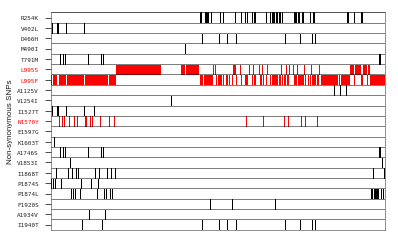

In [7]:
fig, ax = plt.subplots()
plot_missense_haplotypes(ax, h_missense, missense_mutations)

## cluster haplotypes

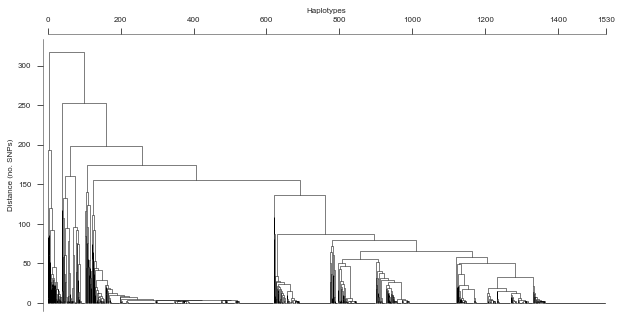

In [8]:
def plot_dendrogram(h, ax, method='complete', color_threshold=0, above_threshold_color='k'):
    
    # compute distance matrix
    dist = allel.stats.pairwise_distance(h, 'hamming') * h.shape[0]

    # HACKING SCIPY TO GET TO OLD CLUSTERING METHOD
    # https://github.com/scipy/scipy/blob/v0.18.1/scipy/cluster/hierarchy.py#L470-L667
    # 1. fiddle with format
    y = _convert_to_double(np.asarray(dist, order='c'))
    # 2. get n
    n = int(distance.num_obs_y(dist))
    # 3. do clustering
    method = dict(single=0, complete=1)[method]
    z = _hierarchy.linkage(y, n, method)    

    # plot dendrogram
    sns.despine(ax=ax, offset=5, bottom=True, top=False)
    r = scipy.cluster.hierarchy.dendrogram(z, no_labels=True, count_sort=True, 
                                           color_threshold=color_threshold, 
                                           above_threshold_color=above_threshold_color,
                                           ax=ax)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, h.shape[1], 200)) + [h.shape[1]])
    xticks = xticklabels / h.shape[1]
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylim(bottom=-10)
#     ax.set_xlim(left=-10)
    ax.set_ylabel('Distance (no. SNPs)')
    ax.autoscale(axis='x', tight=True)
    return z, r

fig, ax = plt.subplots(figsize=(10, 5))
plot_dendrogram(h, ax);

In [9]:
populations = phase1_ar3.pop_ids
pop_colours = phase1_ar3.pop_colors
pop_labels = phase1_ar3.pop_labels

In [10]:
df_haplotypes = phase1_ar31.df_haplotypes
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


In [17]:
def fig_hap_structure(h, h_display=None, mutations=None, vspans=[[]], cluster_labels=[], figsize=(10, 8), 
                      fn=None, dpi=150, height_ratios=(2.5, .2, 2.8, .2), hap_pops=None, legend=True):
    
    # create the figure
    fig = plt.figure(figsize=figsize)
    
    # define subplot layout
    gs_nrows = 4
    gs_ncols = 1
    gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.04, wspace=0.04,
                               height_ratios=height_ratios)
    
    # dendrogram
    ax_dend = fig.add_subplot(gs[0, 0])
    z, r = plot_dendrogram(h, ax_dend, color_threshold=0)
    ax_dend.set_ylim(bottom=-5)
#     for xmin, xmax in vspans:
#         ax.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), 1,
#                                    facecolor='k', edgecolor='k', alpha=.1,
#                                    transform=ax.transAxes, zorder=20))
#     ax.vlines(vspans.flat, 0, 1, transform=ax.transAxes, linestyle=':')
#     if legend:
#         handles = [mpl.patches.Patch(color=pop_colours[pop], label=pop_labels[pop]) for pop in populations]
#         ax_dend.legend(handles=handles, loc='upper right', bbox_to_anchor=(1, 1), ncol=3)
    ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))
    ax_dend.xaxis.set_tick_params(length=3, pad=2)
    ax_dend.yaxis.set_tick_params(length=3, pad=2)

    # population colours
    ax_pops = fig.add_subplot(gs[1, 0])
    if hap_pops is None:
        hap_pops = df_haplotypes.population.values
    x = hap_pops.take(r['leaves'])
    hap_clrs = [pop_colours[p] for p in x]
    ax_pops.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])], yrange=(0, 1), color=hap_clrs);
    sns.despine(ax=ax_pops, offset=5, left=True, bottom=True)
    ax_pops.set_xticks([])
    ax_pops.set_yticks([])
    ax_pops.set_xlim(0, h.shape[1])
    ax_pops.yaxis.set_label_position('left')
    ax_pops.set_ylabel('Population', rotation=0, ha='right', va='center')

    # missense mutations
    if h_display is not None:
        ax_mut = fig.add_subplot(gs[2, 0])
        plot_missense_haplotypes(ax_mut, h_display.take(r['leaves'], axis=1), mutations)
        ax_mut.set_xticks([])
        ax_mut.yaxis.set_tick_params(length=3, pad=2)

    # KDR haplotype clusters
    ax_clu = fig.add_subplot(gs[3, 0])
    sns.despine(ax=ax_clu, bottom=True, left=True)
    ax_clu.set_xlim(0, h.shape[1])
    ax_clu.set_ylim(0, 1)
    for lbl, (xmin, xmax) in zip(cluster_labels, vspans):
        if lbl:
            # hack to get the "fraction" right, which controls length of bracket arms
            fraction = -20 / (xmax - xmin)
            ax_clu.annotate("", ha='left', va='center',
                            xy=(xmin, 1), xycoords='data',
                            xytext=(xmax, 1), textcoords='data',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="bar,fraction=%.4f" % fraction,
                                            ),
                            )
            ax_clu.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=6)
            ax_pops.vlines([xmin, xmax], 0, 1, linestyle=':')
            ax_mut.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), h_display.shape[0],
                             facecolor='k', edgecolor='k', alpha=.1,
                             zorder=20))
            ax_mut.vlines([xmin, xmax], 0, h_display.shape[0], linestyle=':')
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
    ax_clu.set_xlabel('$kdr$ haplotype clusters')
    
    if fn:
        fig.savefig(fn, jpeg_quality=100, dpi=dpi, bbox_inches='tight')
        
    return z, r

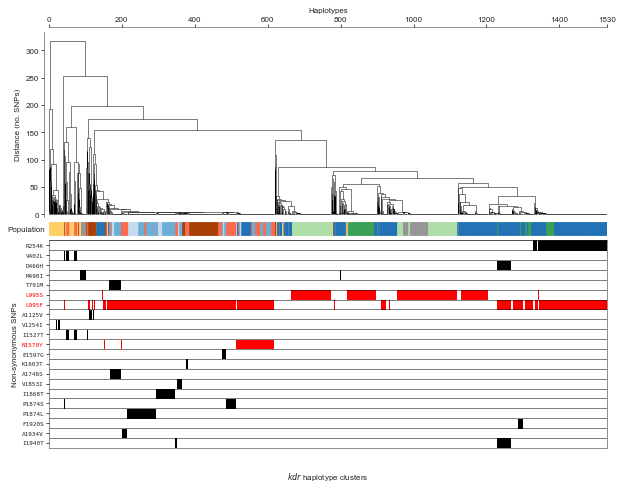

In [18]:
z, r = fig_hap_structure(h, h_missense, missense_mutations)

## cut the dendrogram

In [19]:
# gives the haplotype indices of the haplotypes in the n largest clusters
def find_clusters(z, n, threshold=12):
    
    # find clusters
    f = scipy.cluster.hierarchy.fcluster(z, threshold, criterion='distance')
    
    # compute cluster sizes
    fsz = np.bincount(f)
    
    # sort largest first
    fsort = np.argsort(fsz)[::-1]
    
    # take largest n
    fsort = fsort[:n]
    
    # get haplotype indices for each cluster
    clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
    
    return clusters

In [20]:
def truspan(cluster, r):
    # get the index of the cluster haps in the dendrogram list of all haps
    cluster_leaves = sorted([r['leaves'].index(i) for i in cluster])
    # are these indices monotonic - they should be!
    x = np.asarray(cluster_leaves)
    dx = np.diff(x)
    mon = np.all(dx == 1)
    assert mon
    return min(cluster_leaves), max(cluster_leaves)
    

In [21]:
fig.get_size_inches()

array([ 5.,  4.])

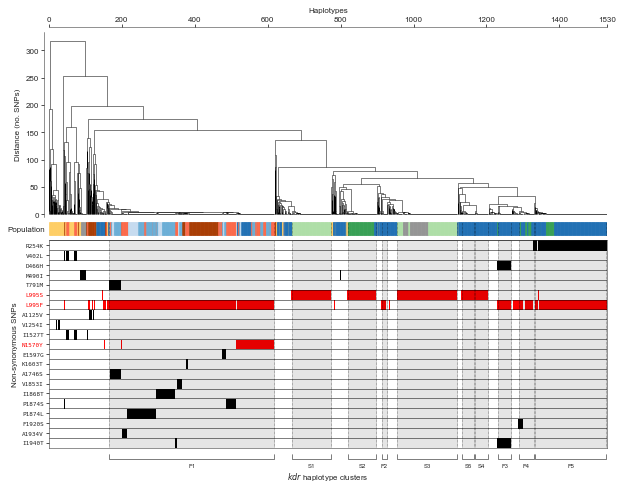

In [29]:
clustard = find_clusters(z, n=15, threshold=10)
vspans = [truspan(cluster, r) for cluster in clustard]
cluster_labels = ['F1', 'F5', 'S3', 'S1', 'S2', 'F4', 'F3', 'S4', 'S5', '', '', '', '', '', 'F2']
fig_hap_structure(h, h_missense, mutations=missense_mutations, vspans=np.array(vspans), cluster_labels=cluster_labels);
fig = plt.gcf()
ax_dend = fig.axes[0]
# ax_dend.text(-0.08, 1.2, 'a', transform=ax_dend.transAxes, ha='left', va='top', fontsize=10, fontweight='bold')
fig.savefig('../artwork/vgsc_haplotypes_hierarchical_clustering.pdf', jpeg_quality=100, dpi=600, bbox_inches='tight')

## generate cluster file

In [30]:
hap_sample_labels = df_haplotypes.ox_code

In [31]:
cluster_samples = dict()
for l, c in zip(cluster_labels, clustard):
    cluster_samples[l] = set(hap_sample_labels.take(list(c)))

In [32]:
def save_cluster_membership(fn, h, clusters, cluster_labels):

    # save cluster membership
    cluster_membership = np.empty(h.shape[1], dtype='S2')
    cluster_membership[:] = b''
    for cluster, lbl in zip(clusters, cluster_labels):
        hidx = sorted(cluster)
        cluster_membership[hidx] = lbl.encode('ascii')[:2]

    np.save(fn, cluster_membership)

In [33]:
save_cluster_membership('../data/hierarchical_cluster_membership.npy', h, clustard, cluster_labels)